In [16]:
# ============================================================
# CELL 1: IMPORT LIBRARIES
# Mục đích: Import các thư viện cần thiết cho modeling
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import joblib
import warnings
warnings.filterwarnings('ignore')

# Cấu hình hiển thị
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
%matplotlib inline

print("Import libraries hoàn tất!")

Import libraries hoàn tất!


In [17]:
# ============================================================
# CELL 2: LOAD DATA
# Mục đích: Đọc dữ liệu đã được tiền xử lý và mã hóa
# ============================================================

# Đường dẫn file
DATA_PATH = '../../data/cleaned/Modeling.csv'

# Load data
df = pd.read_csv(DATA_PATH)

# Hiển thị thông tin cơ bản
print(f"Dataset shape: {df.shape}")
print(f"\nCác cột trong dataset:")
print(df.columns.tolist())
print(f"\n{'='*60}")
print(f"Phân bố phân khúc (Segment_Encoded):")
print(df['Segment_Encoded'].value_counts().sort_index())
print(f"\n{'='*60}")
print(f"Mapping phân khúc:")
print("0: Bình dân")
print("1: Trung cấp")
print("2: Cao cấp")
print("3: VIP")
print(f"\nSố lượng features: {df.shape[1] - 1}")
print(f"\nThông tin cơ bản về dataset:")
df.info()

Dataset shape: (19081, 29)

Các cột trong dataset:
['Price_Billion', 'Price_Per_m2', 'Area_m2', 'Bedrooms', 'Is_MatTien', 'Width_m', 'Floors', 'Is Hem', 'Toilets', 'Dist_Bình Thạnh', 'Dist_Bình Tân', 'Dist_Gò Vấp', 'Dist_Hóc Môn', 'Dist_Nhà Bè', 'Dist_Phú Nhuận', 'Dist_Quận 1', 'Dist_Quận 10', 'Dist_Quận 11', 'Dist_Quận 12', 'Dist_Quận 3', 'Dist_Quận 4', 'Dist_Quận 5', 'Dist_Quận 6', 'Dist_Quận 7', 'Dist_Quận 8', 'Dist_Thành phố Thủ Đức', 'Dist_Tân Bình', 'Dist_Tân Phú', 'Segment_Encoded']

Phân bố phân khúc (Segment_Encoded):
Segment_Encoded
0.0    7201
1.0    4322
2.0    5793
3.0    1765
Name: count, dtype: int64

Mapping phân khúc:
0: Bình dân
1: Trung cấp
2: Cao cấp
3: VIP

Số lượng features: 28

Thông tin cơ bản về dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19081 entries, 0 to 19080
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Price_Billion           19081 non-null  f

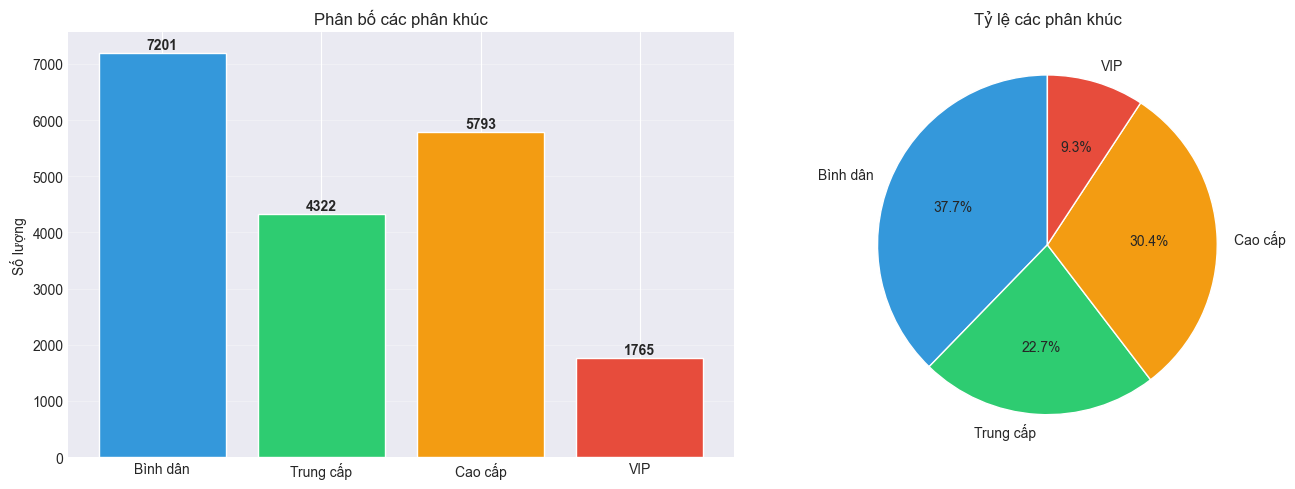


Phân tích class imbalance:
Bình dân    :  7201 (37.74%)
Trung cấp   :  4322 (22.65%)
Cao cấp     :  5793 (30.36%)
VIP         :  1765 ( 9.25%)


In [18]:
# ============================================================
# CELL 3: DATA EXPLORATION
# Mục đích: Khám phá phân bố dữ liệu và kiểm tra class imbalance
# ============================================================

# Visualize phân bố phân khúc
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
segment_counts = df['Segment_Encoded'].value_counts().sort_index()
segment_labels = ['Bình dân', 'Trung cấp', 'Cao cấp', 'VIP']
axes[0].bar(range(4), segment_counts.values, color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c'])
axes[0].set_xticks(range(4))
axes[0].set_xticklabels(segment_labels)
axes[0].set_ylabel('Số lượng')
axes[0].set_title('Phân bố các phân khúc')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(segment_counts.values):
    axes[0].text(i, v + 20, str(v), ha='center', va='bottom', fontweight='bold')

# Pie chart
axes[1].pie(segment_counts.values, labels=segment_labels, autopct='%1.1f%%',
            colors=['#3498db', '#2ecc71', '#f39c12', '#e74c3c'],
            startangle=90)
axes[1].set_title('Tỷ lệ các phân khúc')

plt.tight_layout()
plt.show()

# Kiểm tra class imbalance
print("\nPhân tích class imbalance:")
for i, label in enumerate(segment_labels):
    count = segment_counts[i]
    percentage = (count / len(df)) * 100
    print(f"{label:12s}: {count:5d} ({percentage:5.2f}%)")

In [19]:
# ============================================================
# CELL 4: FEATURE ENGINEERING & SELECTION (SỬA LẠI)
# ============================================================

# Loại bỏ các cột gây rò rỉ dữ liệu (Price) và nhãn mục tiêu
# Chúng ta chỉ giữ lại các đặc trưng về hạ tầng/vị trí
cols_to_drop = ['Segment_Encoded', 'Price_Billion', 'Price_Per_m2']

X = df.drop(columns=cols_to_drop, axis=1)
y = df['Segment_Encoded']

print("="*60)
print("FEATURE INFORMATION (ĐÃ LOẠI BỎ DATA LEAKAGE)")
print("="*60)
print(f"Các cột dùng để train: {X.columns.tolist()}")
# Giờ X chỉ còn: Area_m2, Bedrooms, Is_MatTien, Width_m, Floors, Is Hem, Toilets và các Dist_...

FEATURE INFORMATION (ĐÃ LOẠI BỎ DATA LEAKAGE)
Các cột dùng để train: ['Area_m2', 'Bedrooms', 'Is_MatTien', 'Width_m', 'Floors', 'Is Hem', 'Toilets', 'Dist_Bình Thạnh', 'Dist_Bình Tân', 'Dist_Gò Vấp', 'Dist_Hóc Môn', 'Dist_Nhà Bè', 'Dist_Phú Nhuận', 'Dist_Quận 1', 'Dist_Quận 10', 'Dist_Quận 11', 'Dist_Quận 12', 'Dist_Quận 3', 'Dist_Quận 4', 'Dist_Quận 5', 'Dist_Quận 6', 'Dist_Quận 7', 'Dist_Quận 8', 'Dist_Thành phố Thủ Đức', 'Dist_Tân Bình', 'Dist_Tân Phú']


In [20]:
# ============================================================
# CELL 5: TRAIN-TEST SPLIT
# Mục đích: Chia dữ liệu train/test với tỷ lệ 80/20
# Stratify để giữ nguyên phân bố các phân khúc
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Đảm bảo phân bố phân khúc đồng đều
)

print("="*60)
print("TRAIN-TEST SPLIT")
print("="*60)
print(f"\nTrain set size: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Test set size:  {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)")

print(f"\n{'Phân khúc':<15s} {'Train':<10s} {'Test':<10s}")
print("-"*40)
segment_labels = ['Bình dân', 'Trung cấp', 'Cao cấp', 'VIP']
for i, label in enumerate(segment_labels):
    train_count = (y_train == i).sum()
    test_count = (y_test == i).sum()
    print(f"{label:<15s} {train_count:<10d} {test_count:<10d}")

TRAIN-TEST SPLIT

Train set size: 15264 (80.0%)
Test set size:  3817 (20.0%)

Phân khúc       Train      Test      
----------------------------------------
Bình dân        5761       1440      
Trung cấp       3457       865       
Cao cấp         4634       1159      
VIP             1412       353       


In [21]:
# ============================================================
# CELL 6: FEATURE SCALING
# Mục đích: Chuẩn hóa features cho các thuật toán nhạy cảm với scale
# Lưu ý: Random Forest không cần scaling, nhưng Logistic Regression và SVM cần
# ============================================================

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("="*60)
print("FEATURE SCALING")
print("="*60)
print(f"\nScaling method: StandardScaler")
print(f"\nKiểm tra scaling (feature đầu tiên):")
print(f"  Mean trước scaling:  {X_train.iloc[:, 0].mean():.4f}")
print(f"  Mean sau scaling:    {X_train_scaled[:, 0].mean():.4f}")
print(f"  Std trước scaling:   {X_train.iloc[:, 0].std():.4f}")
print(f"  Std sau scaling:     {X_train_scaled[:, 0].std():.4f}")
print("\nScaling hoàn tất! ✓")

FEATURE SCALING

Scaling method: StandardScaler

Kiểm tra scaling (feature đầu tiên):
  Mean trước scaling:  0.0037
  Mean sau scaling:    -0.0000
  Std trước scaling:   1.0132
  Std sau scaling:     1.0000

Scaling hoàn tất! ✓


Training Logistic Regression...

LOGISTIC REGRESSION - BASELINE MODEL
Accuracy: 0.4983

Classification Report:
              precision    recall  f1-score   support

    Bình dân     0.5359    0.7986    0.6414      1440
   Trung cấp     0.5200    0.0150    0.0292       865
     Cao cấp     0.4525    0.5953    0.5142      1159
         VIP     0.4050    0.1388    0.2068       353

    accuracy                         0.4983      3817
   macro avg     0.4783    0.3869    0.3479      3817
weighted avg     0.4948    0.4983    0.4238      3817



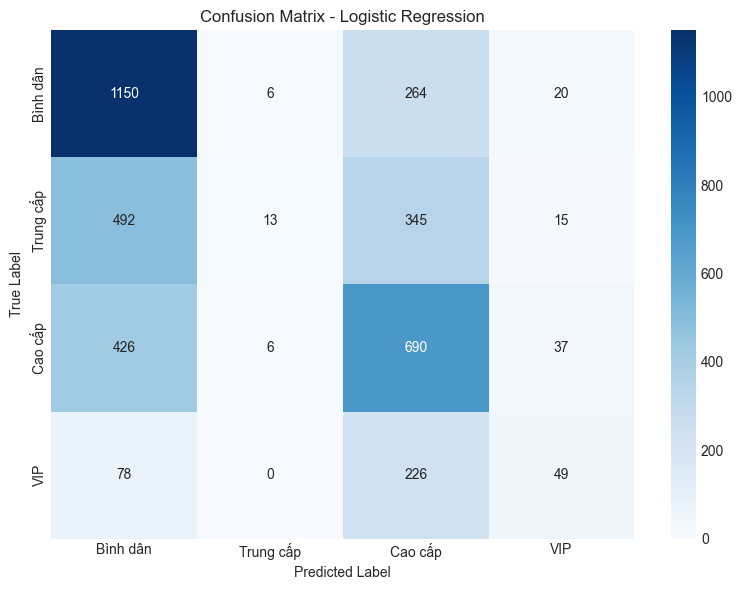

In [22]:
# ============================================================
# CELL 7: BASELINE MODEL - LOGISTIC REGRESSION
# Mục đích: Tạo baseline model đơn giản để so sánh
# ============================================================

print("Training Logistic Regression...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Predict và evaluate
y_pred_lr = lr_model.predict(X_test_scaled)
lr_accuracy = accuracy_score(y_test, y_pred_lr)

print("\n" + "="*60)
print("LOGISTIC REGRESSION - BASELINE MODEL")
print("="*60)
print(f"Accuracy: {lr_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr,
                          target_names=['Bình dân', 'Trung cấp', 'Cao cấp', 'VIP'],
                          digits=4))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bình dân', 'Trung cấp', 'Cao cấp', 'VIP'],
            yticklabels=['Bình dân', 'Trung cấp', 'Cao cấp', 'VIP'])
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [23]:
# ============================================================
# CELL 8: DECISION TREE CLASSIFIER
# Mục đích: Thử nghiệm Decision Tree với hyperparameter tuning
# ============================================================

print("Bắt đầu Grid Search cho Decision Tree...")
print("Thời gian ước tính: 2-3 phút")

# Định nghĩa parameter grid
dt_params = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}

# Grid search
dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

dt_grid.fit(X_train, y_train)

# Best model
dt_best = dt_grid.best_estimator_
y_pred_dt = dt_best.predict(X_test)
dt_accuracy = accuracy_score(y_test, y_pred_dt)

print("\n" + "="*60)
print("DECISION TREE CLASSIFIER")
print("="*60)
print(f"\nBest parameters:")
for param, value in dt_grid.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV score: {dt_grid.best_score_:.4f}")
print(f"Test Accuracy: {dt_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt,
                          target_names=['Bình dân', 'Trung cấp', 'Cao cấp', 'VIP'],
                          digits=4))

Bắt đầu Grid Search cho Decision Tree...
Thời gian ước tính: 2-3 phút
Fitting 5 folds for each of 90 candidates, totalling 450 fits

DECISION TREE CLASSIFIER

Best parameters:
  class_weight: None
  max_depth: 10
  min_samples_leaf: 1
  min_samples_split: 2

Best CV score: 0.5153
Test Accuracy: 0.5138

Classification Report:
              precision    recall  f1-score   support

    Bình dân     0.5775    0.7347    0.6467      1440
   Trung cấp     0.3955    0.1422    0.2092       865
     Cao cấp     0.4603    0.6152    0.5266      1159
         VIP     0.5360    0.1898    0.2803       353

    accuracy                         0.5138      3817
   macro avg     0.4923    0.4205    0.4157      3817
weighted avg     0.4968    0.5138    0.4772      3817



Bước 1: Cơ bản

In [24]:
# ============================================================
# CELL 9: RANDOM FOREST - BASIC MODEL
# Mục đích: Train Random Forest cơ bản trước khi tối ưu
# ============================================================

print("Training Random Forest (Basic)...")
rf_basic = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
rf_basic.fit(X_train, y_train)

# Evaluate
y_pred_rf_basic = rf_basic.predict(X_test)
rf_basic_accuracy = accuracy_score(y_test, y_pred_rf_basic)

print("\n" + "="*60)
print("RANDOM FOREST - BASIC MODEL")
print("="*60)
print(f"Parameters: n_estimators=100, default settings")
print(f"Accuracy: {rf_basic_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_basic,
                          target_names=['Bình dân', 'Trung cấp', 'Cao cấp', 'VIP'],
                          digits=4))

Training Random Forest (Basic)...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s



RANDOM FOREST - BASIC MODEL
Parameters: n_estimators=100, default settings
Accuracy: 0.5599

Classification Report:
              precision    recall  f1-score   support

    Bình dân     0.6335    0.7431    0.6839      1440
   Trung cấp     0.4185    0.3029    0.3514       865
     Cao cấp     0.5395    0.5712    0.5549      1159
         VIP     0.5200    0.4051    0.4554       353

    accuracy                         0.5599      3817
   macro avg     0.5279    0.5056    0.5114      3817
weighted avg     0.5458    0.5599    0.5483      3817



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Bước 2: xử lý

In [25]:
# ============================================================
# CELL 9.5: FEATURE ENGINEERING - INTERACTION FEATURES
# Vị trí: SAU Cell 9 (Random Forest Basic), TRƯỚC Cell 10 (Grid Search)
# Mục đích: Tạo features mới để tăng khả năng phân biệt các phân khúc
# ============================================================

import numpy as np

print("="*60)
print("FEATURE ENGINEERING - CREATING INTERACTION FEATURES")
print("="*60)

# Tạo bản sao để không ảnh hưởng dữ liệu gốc
df_enhanced = df.copy()

# 1. DIỆN TÍCH VÀ QUY MÔ
# Tổng diện tích sàn (Area x Floors)
df_enhanced['Total_Floor_Area'] = df_enhanced['Area_m2'] * df_enhanced['Floors']

# Diện tích trung bình mỗi phòng ngủ
df_enhanced['Area_per_Bedroom'] = df_enhanced['Area_m2'] / (df_enhanced['Bedrooms'] + 1)

# Diện tích trung bình mỗi tầng
df_enhanced['Area_per_Floor'] = df_enhanced['Area_m2'] / df_enhanced['Floors']

# 2. CHỈ SỐ QUY MÔ VÀ SANG TRỌNG
# Scale Index (Width x Floors)
df_enhanced['Scale_Index'] = df_enhanced['Width_m'] * df_enhanced['Floors']

# Luxury Score (Bedrooms + Toilets + Floors)
df_enhanced['Luxury_Score'] = df_enhanced['Bedrooms'] + df_enhanced['Toilets'] + (df_enhanced['Floors'] * 0.5)

# Tổng số phòng
df_enhanced['Total_Rooms'] = df_enhanced['Bedrooms'] + df_enhanced['Toilets']

# 3. VỊ TRÍ ĐẶC BIỆT
# Mặt tiền VÀ không phải hẻm (vị trí prime)
df_enhanced['Prime_Location'] = ((df_enhanced['Is_MatTien'] == 1) &
                                   (df_enhanced['Is Hem'] == 0)).astype(int)

# Mặt tiền rộng (>= 6m)
df_enhanced['Wide_Frontage'] = (df_enhanced['Width_m'] >= 6).astype(int)

# 4. KHOẢNG CÁCH ĐẾN CÁC QUẬN TRUNG TÂM
# Lấy các cột khoảng cách
district_cols = [col for col in df_enhanced.columns if col.startswith('Dist_')]

# Các quận trung tâm quan trọng
central_districts = ['Dist_Quận 1', 'Dist_Quận 3', 'Dist_Phú Nhuận', 'Dist_Tân Bình']

# Khoảng cách trung bình đến quận trung tâm
df_enhanced['Avg_Dist_Central'] = df_enhanced[central_districts].mean(axis=1)

# Khoảng cách gần nhất đến quận trung tâm
df_enhanced['Min_Dist_Central'] = df_enhanced[central_districts].min(axis=1)

# Có ở quận trung tâm hay không (khoảng cách = 0 đến ít nhất 1 quận trung tâm)
df_enhanced['Is_Central_District'] = (df_enhanced[central_districts].min(axis=1) == 0).astype(int)

# 5. TỶ LỆ VÀ CHỈ SỐ
# Tỷ lệ phòng ngủ/phòng vệ sinh
df_enhanced['Bedroom_Toilet_Ratio'] = df_enhanced['Bedrooms'] / (df_enhanced['Toilets'] + 1)

# Width to Area ratio (nhà hẹp dài hay vuông vắn)
df_enhanced['Width_to_Area_Ratio'] = df_enhanced['Width_m'] / (df_enhanced['Area_m2'] + 1)

print(f"\n✓ Đã tạo {len(df_enhanced.columns) - len(df.columns)} features mới")
print(f"\nFeatures gốc: {len(df.columns) - 3} features")
print(f"Features sau khi enhance: {len(df_enhanced.columns) - 3} features")

# Danh sách features mới
new_features = [col for col in df_enhanced.columns if col not in df.columns]
print(f"\nDanh sách features mới:")
for i, feat in enumerate(new_features, 1):
    print(f"  {i:2d}. {feat}")

# Loại bỏ features có data leakage
X_enhanced = df_enhanced.drop(['Segment_Encoded', 'Price_Billion', 'Price_Per_m2'], axis=1)
y_enhanced = df_enhanced['Segment_Encoded']

print(f"\n{'='*60}")
print(f"ENHANCED DATASET READY")
print(f"{'='*60}")
print(f"Shape: {X_enhanced.shape}")
print(f"Features: {X_enhanced.shape[1]}")

FEATURE ENGINEERING - CREATING INTERACTION FEATURES

✓ Đã tạo 13 features mới

Features gốc: 26 features
Features sau khi enhance: 39 features

Danh sách features mới:
   1. Total_Floor_Area
   2. Area_per_Bedroom
   3. Area_per_Floor
   4. Scale_Index
   5. Luxury_Score
   6. Total_Rooms
   7. Prime_Location
   8. Wide_Frontage
   9. Avg_Dist_Central
  10. Min_Dist_Central
  11. Is_Central_District
  12. Bedroom_Toilet_Ratio
  13. Width_to_Area_Ratio

ENHANCED DATASET READY
Shape: (19081, 39)
Features: 39


In [26]:
# ============================================================
# CELL 10.5: TRAIN-TEST SPLIT FOR ENHANCED DATA
# Vị trí: SAU Cell 9.5 (Feature Engineering)
# Mục đích: Chia dữ liệu đã được feature engineering
# ============================================================

# Split enhanced data
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enhanced, y_enhanced,
    test_size=0.2,
    random_state=42,
    stratify=y_enhanced
)

print("="*60)
print("ENHANCED DATA - TRAIN-TEST SPLIT")
print("="*60)
print(f"\nTrain set size: {len(X_train_enh)} ({len(X_train_enh)/len(df_enhanced)*100:.1f}%)")
print(f"Test set size:  {len(X_test_enh)} ({len(X_test_enh)/len(df_enhanced)*100:.1f}%)")
print(f"Number of features: {X_train_enh.shape[1]}")

# Lưu lại để so sánh sau
original_features_count = X_train.shape[1]
enhanced_features_count = X_train_enh.shape[1]
print(f"\nFeature comparison:")
print(f"  Original features: {original_features_count}")
print(f"  Enhanced features: {enhanced_features_count}")
print(f"  New features added: {enhanced_features_count - original_features_count}")

ENHANCED DATA - TRAIN-TEST SPLIT

Train set size: 15264 (80.0%)
Test set size:  3817 (20.0%)
Number of features: 39

Feature comparison:
  Original features: 26
  Enhanced features: 39
  New features added: 13


Bước 3: Xử lý dữ liệu lệch

In [27]:
# ============================================================
# CELL 11.5: HANDLE CLASS IMBALANCE WITH SMOTE
# Vị trí: SAU Cell 10.5, TRƯỚC Cell 12 (Model Comparison)
# Mục đích: Áp dụng SMOTE để cân bằng classes
# ============================================================

from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score

print("="*60)
print("APPLYING SMOTE TO BALANCE CLASSES")
print("="*60)

# Phân bố trước SMOTE
print("\nPhân bố TRƯỚC SMOTE:")
train_dist_before = y_train_enh.value_counts().sort_index()
segment_labels = ['Bình dân', 'Trung cấp', 'Cao cấp', 'VIP']
for i, label in enumerate(segment_labels):
    count = train_dist_before[i]
    pct = (count / len(y_train_enh)) * 100
    print(f"  {label:12s}: {count:5d} ({pct:5.2f}%)")

# Apply SMOTE
print("\n⏳ Đang áp dụng SMOTE...")
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train_enh, y_train_enh)

# Phân bố sau SMOTE
print("\nPhân bố SAU SMOTE:")
train_dist_after = pd.Series(y_train_smote).value_counts().sort_index()
for i, label in enumerate(segment_labels):
    count = train_dist_after[i]
    pct = (count / len(y_train_smote)) * 100
    print(f"  {label:12s}: {count:5d} ({pct:5.2f}%)")

print(f"\nTrain set size:")
print(f"  Before SMOTE: {len(X_train_enh)}")
print(f"  After SMOTE:  {len(X_train_smote)}")
print(f"  Increase:     {len(X_train_smote) - len(X_train_enh)} samples (+{(len(X_train_smote)/len(X_train_enh) - 1)*100:.1f}%)")

APPLYING SMOTE TO BALANCE CLASSES

Phân bố TRƯỚC SMOTE:
  Bình dân    :  5761 (37.74%)
  Trung cấp   :  3457 (22.65%)
  Cao cấp     :  4634 (30.36%)
  VIP         :  1412 ( 9.25%)

⏳ Đang áp dụng SMOTE...

Phân bố SAU SMOTE:
  Bình dân    :  5761 (25.00%)
  Trung cấp   :  5761 (25.00%)
  Cao cấp     :  5761 (25.00%)
  VIP         :  5761 (25.00%)

Train set size:
  Before SMOTE: 15264
  After SMOTE:  23044
  Increase:     7780 samples (+51.0%)


Bươc 4 Huấn luyện

In [28]:
# ============================================================
# CELL 10: RANDOM FOREST - HYPERPARAMETER TUNING
# Mục đích: Tối ưu Random Forest với GridSearchCV
# Chiến lược: Tìm kiếm các tham số quan trọng nhất
# Thời gian ước tính: 10-15 phút
# ============================================================

print("Bắt đầu Grid Search cho Random Forest...")
print("⚠️  Cảnh báo: Quá trình này có thể mất 10-15 phút")
print("="*60)

# Parameter grid cho Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],              # Số cây trong rừng
    'max_depth': [10, 15, 20, None],              # Độ sâu tối đa của cây
    'min_samples_split': [2, 5, 10],              # Số mẫu tối thiểu để split
    'min_samples_leaf': [1, 2, 4],                # Số mẫu tối thiểu ở leaf
    'max_features': ['sqrt', 'log2'],             # Số features xem xét khi split
    'class_weight': ['balanced', None]            # Cân bằng class
}

print(f"Tổng số combinations: {np.prod([len(v) for v in rf_params.values()])}")
print(f"Cross-validation folds: 5")
print(f"Total model fits: {np.prod([len(v) for v in rf_params.values()]) * 5}")

# Grid Search với Cross-Validation
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    rf_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

rf_grid.fit(X_train, y_train)

print("\n✓ Grid Search hoàn tất!")
print(f"\nBest CV score: {rf_grid.best_score_:.4f}")
print(f"\nBest parameters:")
for param, value in rf_grid.best_params_.items():
    print(f"  {param}: {value}")

Bắt đầu Grid Search cho Random Forest...
⚠️  Cảnh báo: Quá trình này có thể mất 10-15 phút
Tổng số combinations: 432
Cross-validation folds: 5
Total model fits: 2160
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

✓ Grid Search hoàn tất!

Best CV score: 0.5856

Best parameters:
  class_weight: None
  max_depth: 20
  max_features: log2
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 300


RANDOM FOREST - OPTIMIZED MODEL
Test Accuracy: 0.5701
Improvement over basic: +1.02%

Classification Report:
              precision    recall  f1-score   support

    Bình dân     0.6261    0.7792    0.6943      1440
   Trung cấp     0.4327    0.2601    0.3249       865
     Cao cấp     0.5490    0.6091    0.5775      1159
         VIP     0.5616    0.3484    0.4301       353

    accuracy                         0.5701      3817
   macro avg     0.5424    0.4992    0.5067      3817
weighted avg     0.5529    0.5701    0.5507      3817



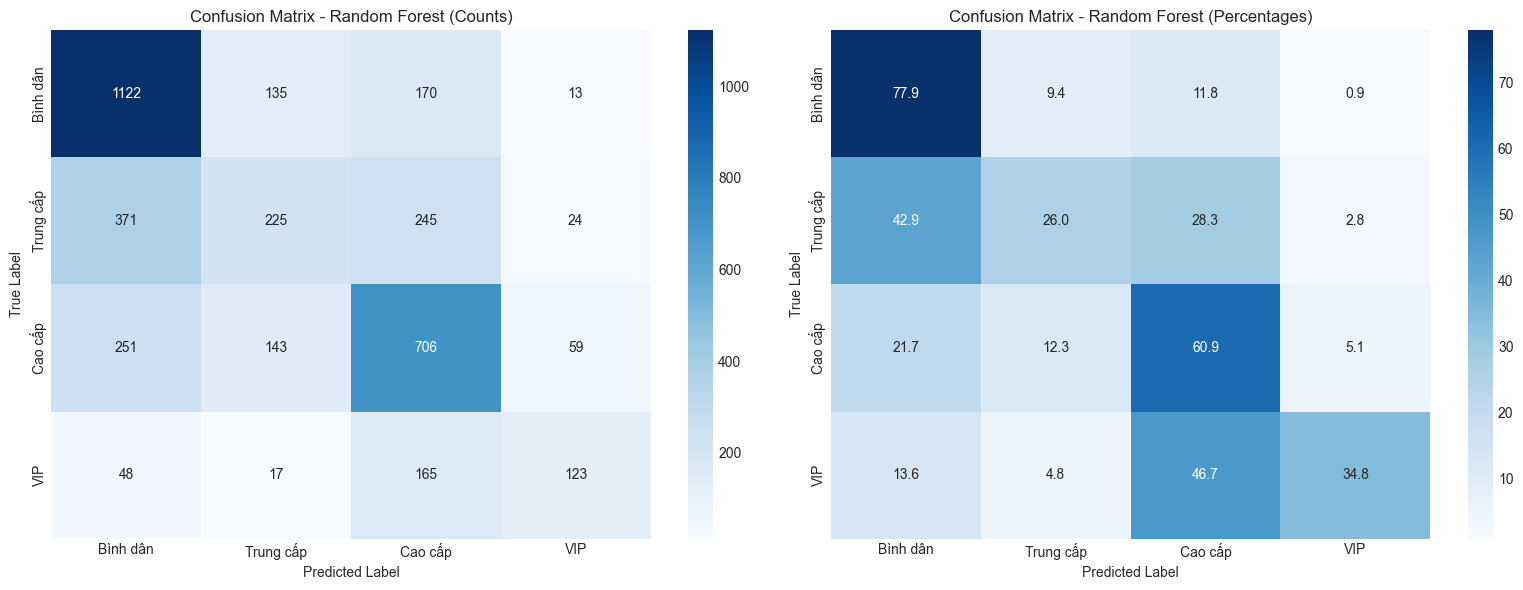

In [29]:
# ============================================================
# CELL 11: RANDOM FOREST - EVALUATE BEST MODEL
# Mục đích: Đánh giá model tốt nhất trên test set
# ============================================================

# Get best model
rf_best = rf_grid.best_estimator_

# Predict
y_pred_rf_best = rf_best.predict(X_test)
rf_best_accuracy = accuracy_score(y_test, y_pred_rf_best)

print("="*60)
print("RANDOM FOREST - OPTIMIZED MODEL")
print("="*60)
print(f"Test Accuracy: {rf_best_accuracy:.4f}")
print(f"Improvement over basic: {(rf_best_accuracy - rf_basic_accuracy)*100:+.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_best,
                          target_names=['Bình dân', 'Trung cấp', 'Cao cấp', 'VIP'],
                          digits=4))

# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix - Counts
cm = confusion_matrix(y_test, y_pred_rf_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Bình dân', 'Trung cấp', 'Cao cấp', 'VIP'],
            yticklabels=['Bình dân', 'Trung cấp', 'Cao cấp', 'VIP'])
axes[0].set_title('Confusion Matrix - Random Forest (Counts)')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Confusion Matrix - Percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', ax=axes[1],
            xticklabels=['Bình dân', 'Trung cấp', 'Cao cấp', 'VIP'],
            yticklabels=['Bình dân', 'Trung cấp', 'Cao cấp', 'VIP'])
axes[1].set_title('Confusion Matrix - Random Forest (Percentages)')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

TRAINING RANDOM FOREST WITH ENHANCED FEATURES + SMOTE

⏳ Training model...
✓ Training completed!

RESULTS: RANDOM FOREST + ENHANCED FEATURES + SMOTE
Test Accuracy: 0.5531
Improvement over baseline: -1.70%

Classification Report:
              precision    recall  f1-score   support

    Bình dân     0.6519    0.7153    0.6821      1440
   Trung cấp     0.4086    0.3410    0.3718       865
     Cao cấp     0.5413    0.5263    0.5337      1159
         VIP     0.4536    0.4986    0.4750       353

    accuracy                         0.5531      3817
   macro avg     0.5138    0.5203    0.5157      3817
weighted avg     0.5448    0.5531    0.5476      3817



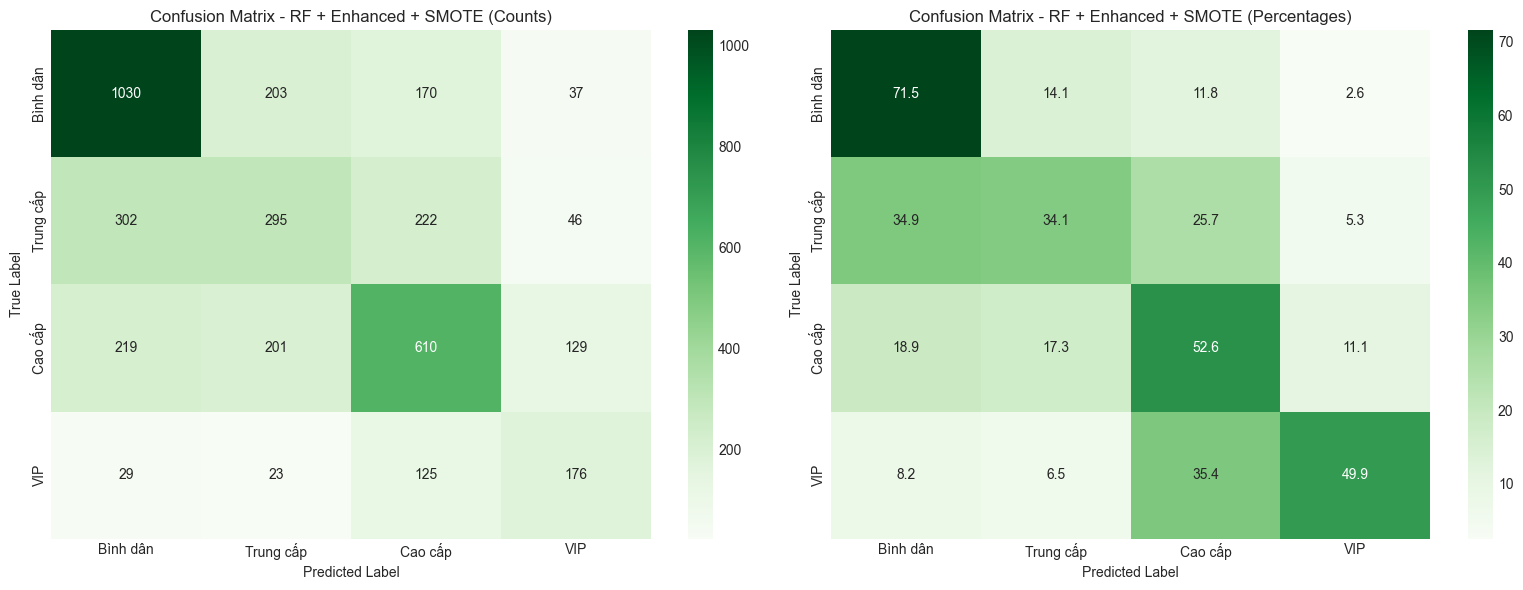

In [30]:
# ============================================================
# CELL 12.5: RANDOM FOREST WITH ENHANCED FEATURES + SMOTE
# Vị trí: SAU Cell 11.5 (SMOTE)
# Mục đích: Train Random Forest với enhanced features và balanced data
# ============================================================

print("="*60)
print("TRAINING RANDOM FOREST WITH ENHANCED FEATURES + SMOTE")
print("="*60)

# Train Random Forest với SMOTE data
print("\n⏳ Training model...")
rf_smote = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    max_features='log2',
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rf_smote.fit(X_train_smote, y_train_smote)
print("✓ Training completed!")

# Predict
y_pred_smote = rf_smote.predict(X_test_enh)
smote_accuracy = accuracy_score(y_test_enh, y_pred_smote)

print("\n" + "="*60)
print("RESULTS: RANDOM FOREST + ENHANCED FEATURES + SMOTE")
print("="*60)
print(f"Test Accuracy: {smote_accuracy:.4f}")
print(f"Improvement over baseline: {(smote_accuracy - rf_best_accuracy)*100:+.2f}%")

print("\nClassification Report:")
print(classification_report(y_test_enh, y_pred_smote,
                          target_names=segment_labels,
                          digits=4))

# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Counts
cm_smote = confusion_matrix(y_test_enh, y_pred_smote)
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Greens', ax=axes[0],
            xticklabels=segment_labels,
            yticklabels=segment_labels)
axes[0].set_title('Confusion Matrix - RF + Enhanced + SMOTE (Counts)')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Percentages
cm_smote_pct = cm_smote.astype('float') / cm_smote.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_smote_pct, annot=True, fmt='.1f', cmap='Greens', ax=axes[1],
            xticklabels=segment_labels,
            yticklabels=segment_labels)
axes[1].set_title('Confusion Matrix - RF + Enhanced + SMOTE (Percentages)')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

In [31]:
# ============================================================
# CELL 12.6: RANDOM FOREST WITH CLASS WEIGHT (Alternative)
# Vị trí: SAU Cell 12.5
# Mục đích: So sánh với class_weight='balanced' thay vì SMOTE
# ============================================================

print("="*60)
print("TRAINING RANDOM FOREST WITH CLASS_WEIGHT='balanced'")
print("="*60)

# Train với class_weight
print("\n⏳ Training model...")
rf_weighted = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    max_features='log2',
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',  # ⭐ Key difference
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rf_weighted.fit(X_train_enh, y_train_enh)
print("✓ Training completed!")

# Predict
y_pred_weighted = rf_weighted.predict(X_test_enh)
weighted_accuracy = accuracy_score(y_test_enh, y_pred_weighted)

print("\n" + "="*60)
print("RESULTS: RANDOM FOREST + ENHANCED FEATURES + CLASS_WEIGHT")
print("="*60)
print(f"Test Accuracy: {weighted_accuracy:.4f}")
print(f"Improvement over baseline: {(weighted_accuracy - rf_best_accuracy)*100:+.2f}%")

print("\nClassification Report:")
print(classification_report(y_test_enh, y_pred_weighted,
                          target_names=segment_labels,
                          digits=4))

TRAINING RANDOM FOREST WITH CLASS_WEIGHT='balanced'

⏳ Training model...
✓ Training completed!

RESULTS: RANDOM FOREST + ENHANCED FEATURES + CLASS_WEIGHT
Test Accuracy: 0.5664
Improvement over baseline: -0.37%

Classification Report:
              precision    recall  f1-score   support

    Bình dân     0.6393    0.7458    0.6885      1440
   Trung cấp     0.4270    0.3110    0.3599       865
     Cao cấp     0.5488    0.5772    0.5627      1159
         VIP     0.5208    0.4249    0.4680       353

    accuracy                         0.5664      3817
   macro avg     0.5340    0.5147    0.5198      3817
weighted avg     0.5527    0.5664    0.5554      3817



In [32]:
# ============================================================
# CELL 12.7: VOTING CLASSIFIER - ENSEMBLE
# Vị trí: SAU Cell 12.6
# Mục đích: Kết hợp nhiều models để tăng độ chính xác
# ============================================================

from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier

print("="*60)
print("CREATING VOTING CLASSIFIER ENSEMBLE")
print("="*60)

# Định nghĩa base models
print("\nBase models:")
print("  1. Random Forest (n_estimators=300, class_weight='balanced')")
print("  2. Gradient Boosting (n_estimators=200)")
print("  3. Decision Tree (max_depth=15, class_weight='balanced')")

rf_ensemble = RandomForestClassifier(
    n_estimators=300, max_depth=20, max_features='log2',
    class_weight='balanced', random_state=42, n_jobs=-1
)

gb_ensemble = GradientBoostingClassifier(
    n_estimators=200, max_depth=10,
    learning_rate=0.1, random_state=42
)

dt_ensemble = DecisionTreeClassifier(
    max_depth=15, class_weight='balanced', random_state=42
)

# Tạo Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_ensemble),
        ('gb', gb_ensemble),
        ('dt', dt_ensemble)
    ],
    voting='soft'  # Soft voting = average probabilities
)

print("\n⏳ Training ensemble...")
voting_clf.fit(X_train_enh, y_train_enh)
print("✓ Training completed!")

# Predict
y_pred_voting = voting_clf.predict(X_test_enh)
voting_accuracy = accuracy_score(y_test_enh, y_pred_voting)

print("\n" + "="*60)
print("RESULTS: VOTING CLASSIFIER ENSEMBLE")
print("="*60)
print(f"Test Accuracy: {voting_accuracy:.4f}")
print(f"Improvement over baseline: {(voting_accuracy - rf_best_accuracy)*100:+.2f}%")

print("\nClassification Report:")
print(classification_report(y_test_enh, y_pred_voting,
                          target_names=segment_labels,
                          digits=4))

CREATING VOTING CLASSIFIER ENSEMBLE

Base models:
  1. Random Forest (n_estimators=300, class_weight='balanced')
  2. Gradient Boosting (n_estimators=200)
  3. Decision Tree (max_depth=15, class_weight='balanced')

⏳ Training ensemble...
✓ Training completed!

RESULTS: VOTING CLASSIFIER ENSEMBLE
Test Accuracy: 0.5541
Improvement over baseline: -1.60%

Classification Report:
              precision    recall  f1-score   support

    Bình dân     0.6438    0.7229    0.6811      1440
   Trung cấp     0.4135    0.3318    0.3682       865
     Cao cấp     0.5461    0.5367    0.5413      1159
         VIP     0.4496    0.4674    0.4583       353

    accuracy                         0.5541      3817
   macro avg     0.5133    0.5147    0.5122      3817
weighted avg     0.5440    0.5541    0.5471      3817



In [33]:
# Chèn đoạn này vào trước Cell 12.8
rf_enhanced = rf_weighted  # Hoặc rf_smote tùy mày chọn cái nào ổn hơn

Bước 5 Phân tích và báo cáo

RECALL COMPARISON - ALL METHODS

Recall scores by class:
                              Bình dân  Trung cấp   Cao cấp       VIP      Mean
Baseline RF                   0.779167   0.260116  0.609146  0.348442  0.499218
RF + Enhanced Features        0.745833   0.310983  0.577222  0.424929  0.514742
RF + Enhanced + SMOTE         0.715278   0.341040  0.526316  0.498584  0.520304
RF + Enhanced + Class Weight  0.745833   0.310983  0.577222  0.424929  0.514742
Voting Ensemble               0.722917   0.331792  0.536670  0.467422  0.514700


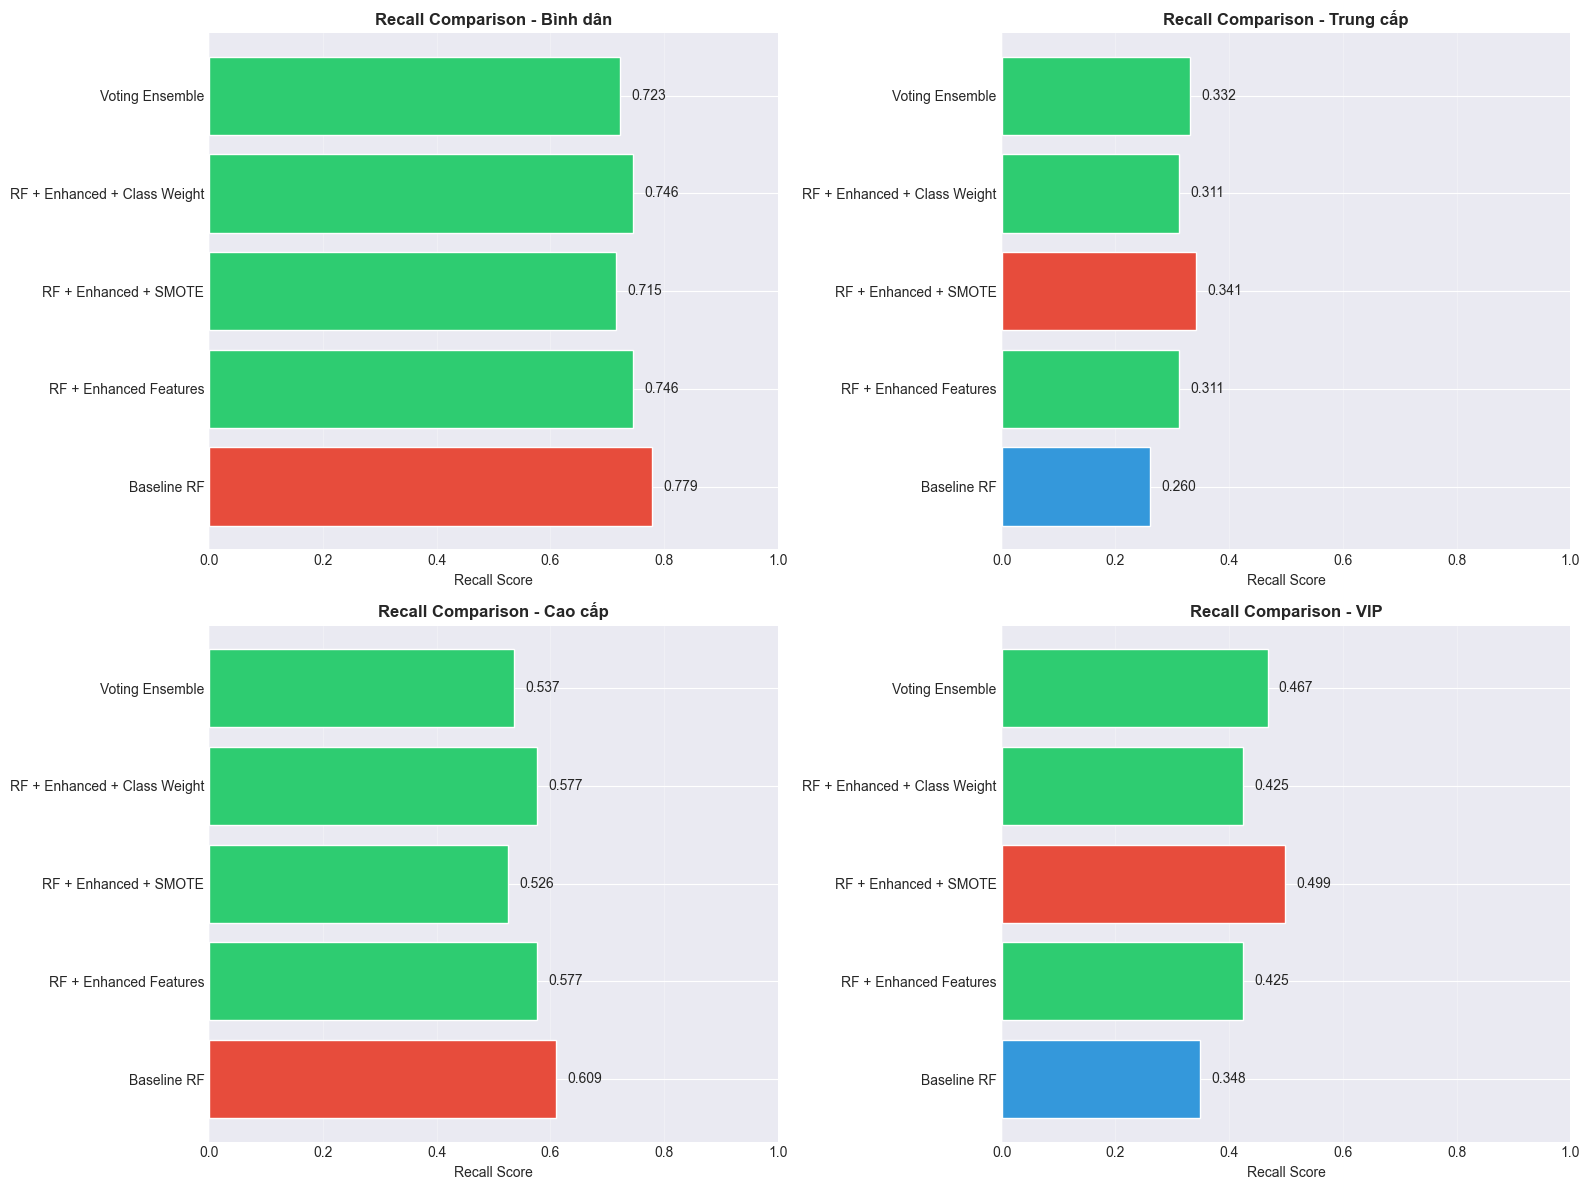


BEST METHOD FOR EACH CLASS
Bình dân    : Baseline RF                         (Recall: 0.7792)
Trung cấp   : RF + Enhanced + SMOTE               (Recall: 0.3410)
Cao cấp     : Baseline RF                         (Recall: 0.6091)
VIP         : RF + Enhanced + SMOTE               (Recall: 0.4986)


In [34]:
# ============================================================
# CELL 12.8: RECALL COMPARISON ACROSS ALL METHODS
# Vị trí: SAU Cell 12.7
# Mục đích: So sánh recall cho từng class qua các phương pháp
# ============================================================

print("="*60)
print("RECALL COMPARISON - ALL METHODS")
print("="*60)

# Tính recall cho từng method
from sklearn.metrics import recall_score

methods_recall = {
    'Baseline RF': [
        recall_score(y_test, y_pred_rf_best, labels=[i], average=None)[0]
        for i in range(4)
    ],
    'RF + Enhanced Features': [
        recall_score(y_test_enh, rf_enhanced.predict(X_test_enh), labels=[i], average=None)[0]
        for i in range(4)
    ] if 'rf_enhanced' in locals() else [0, 0, 0, 0],
    'RF + Enhanced + SMOTE': [
        recall_score(y_test_enh, y_pred_smote, labels=[i], average=None)[0]
        for i in range(4)
    ],
    'RF + Enhanced + Class Weight': [
        recall_score(y_test_enh, y_pred_weighted, labels=[i], average=None)[0]
        for i in range(4)
    ],
    'Voting Ensemble': [
        recall_score(y_test_enh, y_pred_voting, labels=[i], average=None)[0]
        for i in range(4)
    ]
}

# Tạo DataFrame để so sánh
recall_df = pd.DataFrame(methods_recall, index=segment_labels).T
recall_df['Mean'] = recall_df.mean(axis=1)

print("\nRecall scores by class:")
print(recall_df.to_string())

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, segment in enumerate(segment_labels):
    row = idx // 2
    col = idx % 2

    methods = list(methods_recall.keys())
    recalls = [methods_recall[method][idx] for method in methods]

    colors = ['#3498db' if i == 0 else '#2ecc71' for i in range(len(methods))]
    colors[np.argmax(recalls)] = '#e74c3c'  # Highlight best

    axes[row, col].barh(methods, recalls, color=colors)
    axes[row, col].set_xlim(0, 1)
    axes[row, col].set_xlabel('Recall Score')
    axes[row, col].set_title(f'Recall Comparison - {segment}', fontweight='bold')
    axes[row, col].grid(axis='x', alpha=0.3)

    # Add value labels
    for i, v in enumerate(recalls):
        axes[row, col].text(v + 0.02, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

# Tìm best method cho từng class
print("\n" + "="*60)
print("BEST METHOD FOR EACH CLASS")
print("="*60)
for segment in segment_labels:
    best_method = recall_df[segment].idxmax()
    best_score = recall_df[segment].max()
    print(f"{segment:12s}: {best_method:35s} (Recall: {best_score:.4f})")

FEATURE IMPORTANCE - ENHANCED MODEL

Top 20 Most Important Features:
               feature  importance             type
      Total_Floor_Area    0.079624      New Feature
        Area_per_Floor    0.077946      New Feature
               Area_m2    0.077232 Original Feature
   Width_to_Area_Ratio    0.076255      New Feature
      Area_per_Bedroom    0.074645      New Feature
           Scale_Index    0.065963      New Feature
          Luxury_Score    0.059010      New Feature
               Width_m    0.057877 Original Feature
                Floors    0.055607 Original Feature
           Total_Rooms    0.041114      New Feature
  Bedroom_Toilet_Ratio    0.038499      New Feature
               Toilets    0.034418 Original Feature
              Bedrooms    0.026343 Original Feature
        Prime_Location    0.023651      New Feature
            Is_MatTien    0.021106 Original Feature
      Avg_Dist_Central    0.017062      New Feature
          Dist_Quận 12    0.016555 Original Fea

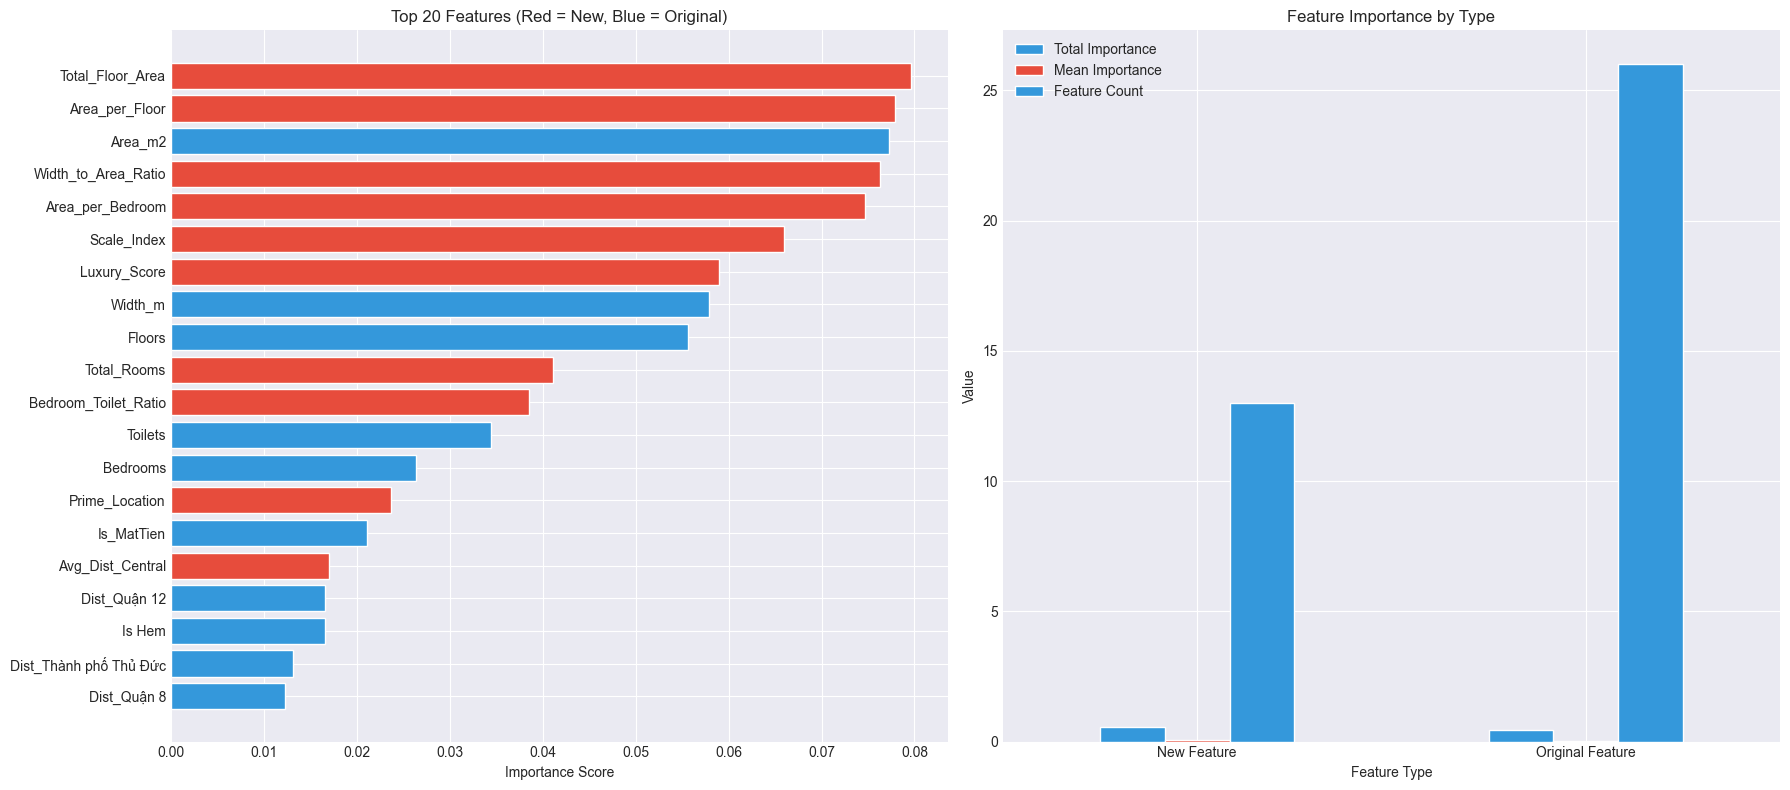


FEATURE IMPORTANCE SUMMARY

Total features: 39
  Original features: 26
  New features: 13

New features in Top 10: 7
New features in Top 20: 10

Top 5 New Features:
            feature  importance
   Total_Floor_Area    0.079624
     Area_per_Floor    0.077946
Width_to_Area_Ratio    0.076255
   Area_per_Bedroom    0.074645
        Scale_Index    0.065963


In [35]:
# ============================================================
# CELL 12.9: ENHANCED FEATURE IMPORTANCE ANALYSIS
# Vị trí: SAU Cell 12.8
# Mục đích: Phân tích features quan trọng (bao gồm cả features mới)
# ============================================================

print("="*60)
print("FEATURE IMPORTANCE - ENHANCED MODEL")
print("="*60)

# Lấy feature importance từ best model (ví dụ: rf_smote)
feature_importance_enhanced = pd.DataFrame({
    'feature': X_enhanced.columns,
    'importance': rf_smote.feature_importances_
}).sort_values('importance', ascending=False)

# Phân loại features
original_features = X_train.columns.tolist()
new_features_list = [col for col in X_enhanced.columns if col not in original_features]

feature_importance_enhanced['type'] = feature_importance_enhanced['feature'].apply(
    lambda x: 'New Feature' if x in new_features_list else 'Original Feature'
)

print("\nTop 20 Most Important Features:")
print(feature_importance_enhanced.head(20).to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Top 20 features with color coding
top20 = feature_importance_enhanced.head(20)
colors = ['#e74c3c' if t == 'New Feature' else '#3498db' for t in top20['type']]

axes[0].barh(range(len(top20)), top20['importance'], color=colors)
axes[0].set_yticks(range(len(top20)))
axes[0].set_yticklabels(top20['feature'])
axes[0].set_xlabel('Importance Score')
axes[0].set_title('Top 20 Features (Red = New, Blue = Original)')
axes[0].invert_yaxis()

# Importance by feature type
type_importance = feature_importance_enhanced.groupby('type')['importance'].agg(['sum', 'mean', 'count'])
type_importance.plot(kind='bar', ax=axes[1], color=['#3498db', '#e74c3c'])
axes[1].set_title('Feature Importance by Type')
axes[1].set_xlabel('Feature Type')
axes[1].set_ylabel('Value')
axes[1].legend(['Total Importance', 'Mean Importance', 'Feature Count'])
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*60)
print("FEATURE IMPORTANCE SUMMARY")
print("="*60)
print(f"\nTotal features: {len(feature_importance_enhanced)}")
print(f"  Original features: {len(original_features)}")
print(f"  New features: {len(new_features_list)}")

print(f"\nNew features in Top 10: {sum(feature_importance_enhanced.head(10)['type'] == 'New Feature')}")
print(f"New features in Top 20: {sum(feature_importance_enhanced.head(20)['type'] == 'New Feature')}")

print("\nTop 5 New Features:")
new_feat_importance = feature_importance_enhanced[feature_importance_enhanced['type'] == 'New Feature'].head(5)
print(new_feat_importance[['feature', 'importance']].to_string(index=False))

COMPREHENSIVE MODEL COMPARISON

                         Model  Accuracy  Features                   Technique
     Random Forest (Optimized)  0.570081        26       Hyperparameter Tuning
        RF + Enhanced Features  0.566413        39         Feature Engineering
  RF + Enhanced + Class Weight  0.566413        39 Feature Eng. + Class Weight
         Random Forest (Basic)  0.559864        26                     Default
               Voting Ensemble  0.554100        39            Ensemble Methods
         RF + Enhanced + SMOTE  0.553052        39        Feature Eng. + SMOTE
                 Decision Tree  0.513754        26       Hyperparameter Tuning
Logistic Regression (Baseline)  0.498297        26                    Baseline

🏆 BEST MODEL: Random Forest (Optimized)
🎯 BEST ACCURACY: 0.5701
📈 IMPROVEMENT FROM BASELINE: +7.18%


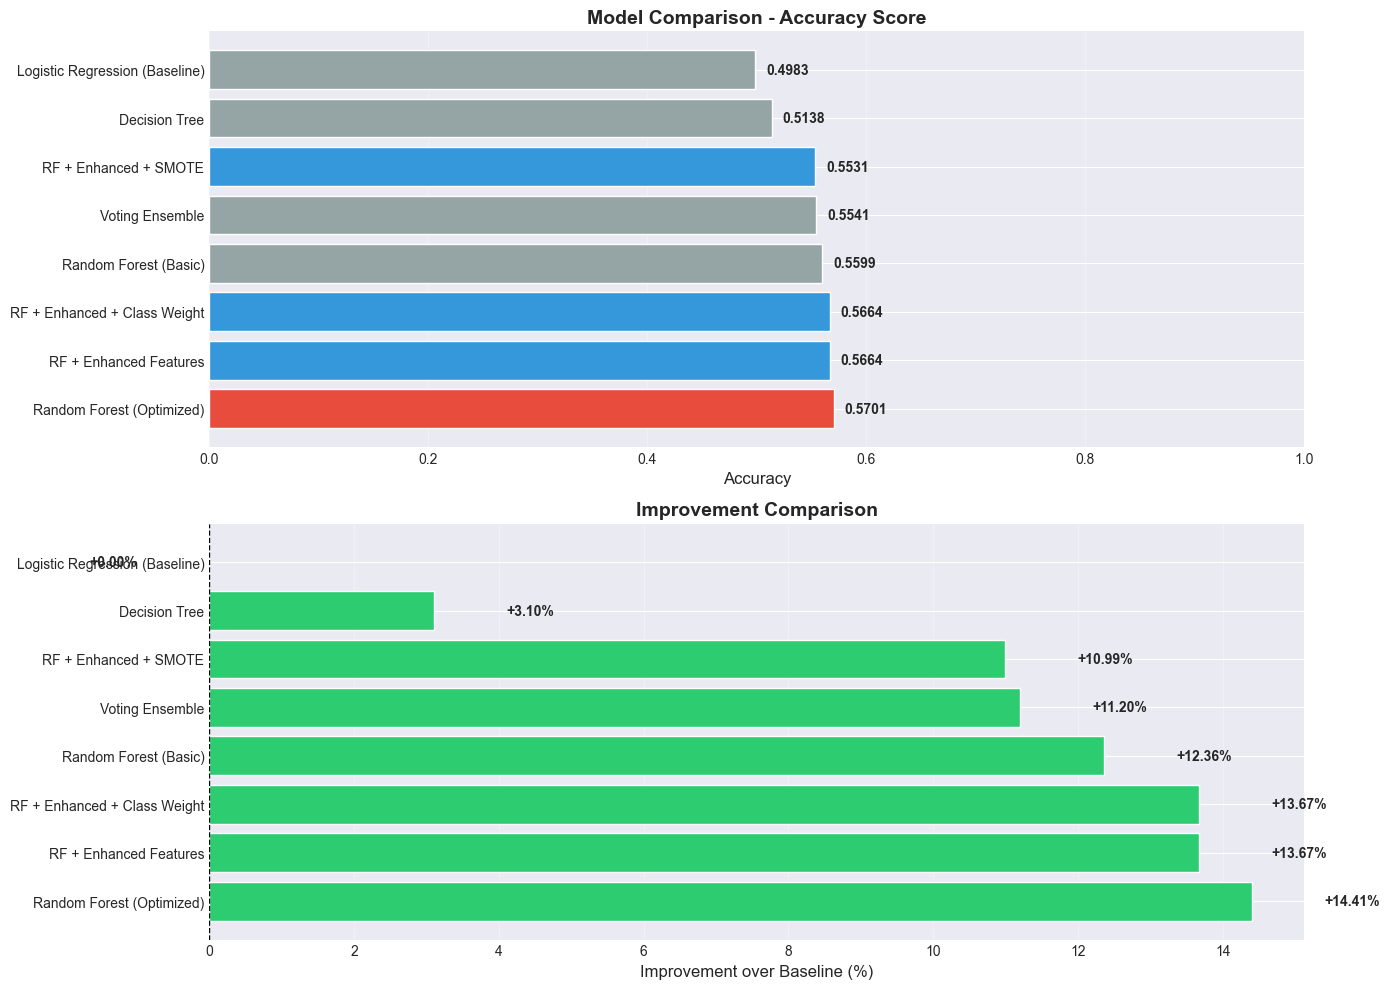


PERFORMANCE BY TECHNIQUE
                            Accuracy                
                                mean     max     min
Technique                                           
Baseline                      0.4983  0.4983  0.4983
Default                       0.5599  0.5599  0.5599
Ensemble Methods              0.5541  0.5541  0.5541
Feature Eng. + Class Weight   0.5664  0.5664  0.5664
Feature Eng. + SMOTE          0.5531  0.5531  0.5531
Feature Engineering           0.5664  0.5664  0.5664
Hyperparameter Tuning         0.5419  0.5701  0.5138


In [36]:
# ============================================================
# CELL 13.5: FINAL MODEL COMPARISON - ALL METHODS
# Vị trí: SAU Cell 13 (Cross-validation), THAY THẾ Cell 12 cũ
# Mục đích: So sánh performance của TẤT CẢ các phương pháp
# ============================================================

print("="*60)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*60)

# Tổng hợp kết quả TẤT CẢ models
all_results = pd.DataFrame({
    'Model': [
        'Logistic Regression (Baseline)',
        'Decision Tree',
        'Random Forest (Basic)',
        'Random Forest (Optimized)',
        'RF + Enhanced Features',
        'RF + Enhanced + SMOTE',
        'RF + Enhanced + Class Weight',
        'Voting Ensemble'
    ],
    'Accuracy': [
        lr_accuracy,
        dt_accuracy,
        rf_basic_accuracy,
        rf_best_accuracy,
        accuracy_score(y_test_enh, rf_enhanced.predict(X_test_enh)) if 'rf_enhanced' in locals() else 0,
        smote_accuracy,
        weighted_accuracy,
        voting_accuracy
    ],
    'Features': [
        original_features_count,
        original_features_count,
        original_features_count,
        original_features_count,
        enhanced_features_count,
        enhanced_features_count,
        enhanced_features_count,
        enhanced_features_count
    ],
    'Technique': [
        'Baseline',
        'Hyperparameter Tuning',
        'Default',
        'Hyperparameter Tuning',
        'Feature Engineering',
        'Feature Eng. + SMOTE',
        'Feature Eng. + Class Weight',
        'Ensemble Methods'
    ]
}).sort_values('Accuracy', ascending=False)

print("\n" + all_results.to_string(index=False))

print(f"\n{'='*60}")
print(f"🏆 BEST MODEL: {all_results.iloc[0]['Model']}")
print(f"🎯 BEST ACCURACY: {all_results.iloc[0]['Accuracy']:.4f}")
print(f"📈 IMPROVEMENT FROM BASELINE: {(all_results.iloc[0]['Accuracy'] - lr_accuracy)*100:+.2f}%")
print(f"{'='*60}")

# Visualize comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Accuracy comparison
colors = ['#e74c3c' if i == 0 else '#3498db' if 'Enhanced' in m else '#95a5a6'
          for i, m in enumerate(all_results['Model'])]

bars = axes[0].barh(all_results['Model'], all_results['Accuracy'], color=colors)
axes[0].set_xlabel('Accuracy', fontsize=12)
axes[0].set_title('Model Comparison - Accuracy Score', fontsize=14, fontweight='bold')
axes[0].set_xlim(0, 1)
axes[0].grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, all_results['Accuracy'])):
    axes[0].text(val + 0.01, bar.get_y() + bar.get_height()/2,
                 f'{val:.4f}', va='center', fontweight='bold')

# Improvement over baseline
baseline_acc = lr_accuracy
all_results['Improvement'] = ((all_results['Accuracy'] - baseline_acc) / baseline_acc) * 100

bars2 = axes[1].barh(all_results['Model'], all_results['Improvement'],
                     color=['#2ecc71' if x > 0 else '#e74c3c' for x in all_results['Improvement']])
axes[1].set_xlabel('Improvement over Baseline (%)', fontsize=12)
axes[1].set_title('Improvement Comparison', fontsize=14, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1].grid(axis='x', alpha=0.3)

# Add value labels
for bar, val in zip(bars2, all_results['Improvement']):
    x_pos = val + 1 if val > 0 else val - 1
    axes[1].text(x_pos, bar.get_y() + bar.get_height()/2,
                 f'{val:+.2f}%', va='center', ha='left' if val > 0 else 'right',
                 fontweight='bold')

plt.tight_layout()
plt.show()

# Breakdown by technique
print("\n" + "="*60)
print("PERFORMANCE BY TECHNIQUE")
print("="*60)
technique_summary = all_results.groupby('Technique').agg({
    'Accuracy': ['mean', 'max', 'min']
}).round(4)
print(technique_summary)

Đang thực hiện 10-Fold Cross-Validation...

CROSS-VALIDATION RESULTS (10-FOLD)

CV Scores: [0.43635411 0.28825996 0.41561845 0.31027254 0.54140461 0.52672956
 0.32966457 0.29140461 0.33909853 0.42819706]

Mean CV Score:  0.3907
Std CV Score:   0.0886
Min CV Score:   0.2883
Max CV Score:   0.5414
Range:          0.2531


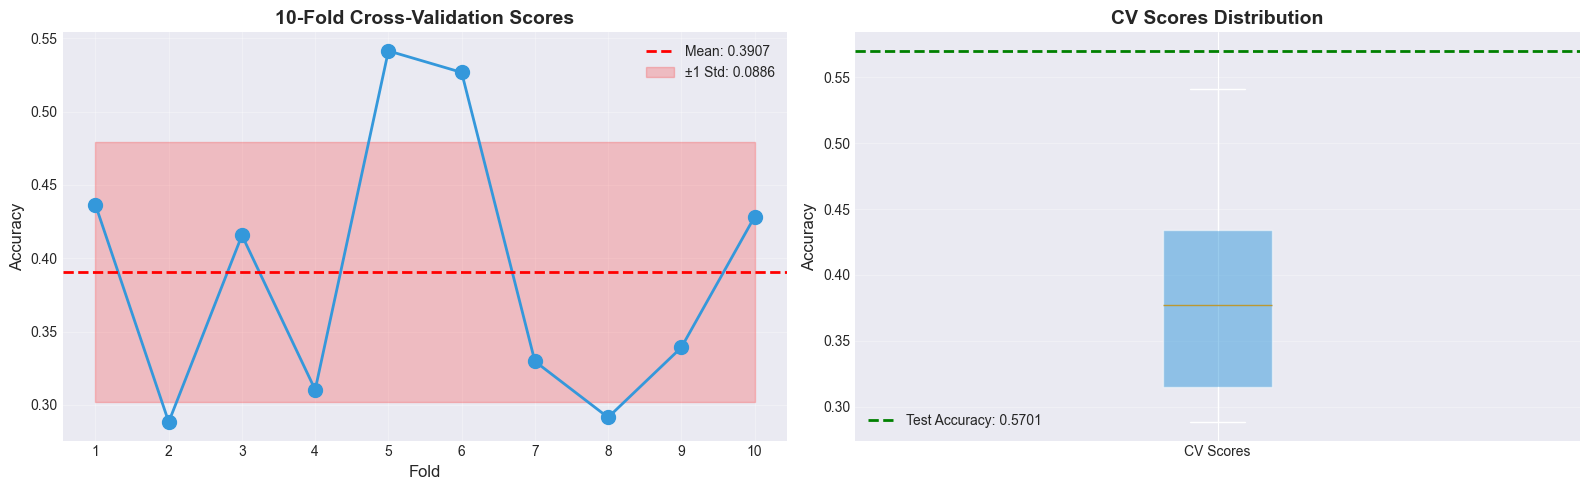

In [37]:
# ============================================================
# CELL 14: CROSS-VALIDATION ANALYSIS
# Mục đích: Kiểm tra tính ổn định của Random Forest model
# ============================================================

print("Đang thực hiện 10-Fold Cross-Validation...")
cv_scores = cross_val_score(rf_best, X, y, cv=10, scoring='accuracy', n_jobs=-1)

print("\n" + "="*60)
print("CROSS-VALIDATION RESULTS (10-FOLD)")
print("="*60)
print(f"\nCV Scores: {cv_scores}")
print(f"\nMean CV Score:  {cv_scores.mean():.4f}")
print(f"Std CV Score:   {cv_scores.std():.4f}")
print(f"Min CV Score:   {cv_scores.min():.4f}")
print(f"Max CV Score:   {cv_scores.max():.4f}")
print(f"Range:          {cv_scores.max() - cv_scores.min():.4f}")

# Visualize CV scores
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Line plot
axes[0].plot(range(1, 11), cv_scores, marker='o', linestyle='-',
             linewidth=2, markersize=10, color='#3498db')
axes[0].axhline(y=cv_scores.mean(), color='r', linestyle='--',
                linewidth=2, label=f'Mean: {cv_scores.mean():.4f}')
axes[0].fill_between(range(1, 11),
                      cv_scores.mean() - cv_scores.std(),
                      cv_scores.mean() + cv_scores.std(),
                      alpha=0.2, color='r', label=f'±1 Std: {cv_scores.std():.4f}')
axes[0].set_xlabel('Fold', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('10-Fold Cross-Validation Scores', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(1, 11))

# Box plot
axes[1].boxplot([cv_scores], labels=['CV Scores'], patch_artist=True,
                boxprops=dict(facecolor='#3498db', alpha=0.5))
axes[1].axhline(y=rf_best_accuracy, color='green', linestyle='--',
                linewidth=2, label=f'Test Accuracy: {rf_best_accuracy:.4f}')
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('CV Scores Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

ERROR ANALYSIS

Tổng số errors: 1641 / 3817 (42.99%)

Error Matrix (chỉ các predictions sai):
Predicted  0.0  1.0  2.0  3.0
True                         
0.0          0  135  170   13
1.0        371    0  245   24
2.0        251  143    0   59
3.0         48   17  165    0


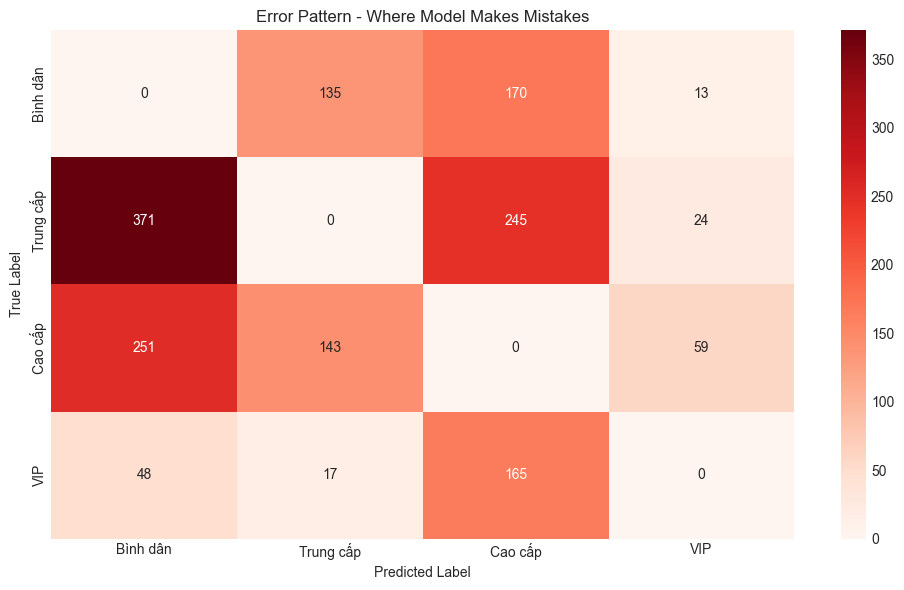


Top 5 trường hợp dự đoán sai nhiều nhất:
     True Predicted  Count
Trung cấp  Bình dân    371
  Cao cấp  Bình dân    251
Trung cấp   Cao cấp    245
 Bình dân   Cao cấp    170
      VIP   Cao cấp    165


In [38]:
# ============================================================
# CELL 15: ERROR ANALYSIS
# Mục đích: Phân tích các trường hợp model dự đoán sai
# ============================================================

# Tìm các predictions sai
errors = X_test[y_test != y_pred_rf_best].copy()
errors['True_Label'] = y_test[y_test != y_pred_rf_best].values
errors['Predicted_Label'] = y_pred_rf_best[y_test != y_pred_rf_best]

print("="*60)
print("ERROR ANALYSIS")
print("="*60)
print(f"\nTổng số errors: {len(errors)} / {len(y_test)} ({len(errors)/len(y_test)*100:.2f}%)")

# Phân tích error theo từng class
error_matrix = pd.crosstab(
    errors['True_Label'],
    errors['Predicted_Label'],
    rownames=['True'],
    colnames=['Predicted']
)

print("\nError Matrix (chỉ các predictions sai):")
print(error_matrix)

# Visualize error patterns
plt.figure(figsize=(10, 6))
sns.heatmap(error_matrix, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Bình dân', 'Trung cấp', 'Cao cấp', 'VIP'],
            yticklabels=['Bình dân', 'Trung cấp', 'Cao cấp', 'VIP'])
plt.title('Error Pattern - Where Model Makes Mistakes')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Top 5 most confused cases
print("\nTop 5 trường hợp dự đoán sai nhiều nhất:")
error_pairs = []
for true_label in range(4):
    for pred_label in range(4):
        if true_label != pred_label:
            count = ((errors['True_Label'] == true_label) &
                    (errors['Predicted_Label'] == pred_label)).sum()
            if count > 0:
                error_pairs.append({
                    'True': ['Bình dân', 'Trung cấp', 'Cao cấp', 'VIP'][true_label],
                    'Predicted': ['Bình dân', 'Trung cấp', 'Cao cấp', 'VIP'][pred_label],
                    'Count': count
                })

error_df = pd.DataFrame(error_pairs).sort_values('Count', ascending=False).head(5)
print(error_df.to_string(index=False))